# Question 5: RNN - LSTM (1.5 điểm)
- Use AAPL.csv dataset or dowload from link https://finance.yahoo.com/quote/AAPL/history?period1=1479081600&period2=1605312000&interval=1d&filter=history&frequency=1d&includeAdjustedClose=true
### Requirement:
- Build a model to predict the tomorrow's **Open** value based on the today's **Open, High, Low, Close, Adj Close, Volume**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model, Sequential
from tensorflow.keras.layers import Dense, Input

from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV

In [30]:
import numpy
import matplotlib.pyplot as plt
import math
import pandas as pd
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM, Bidirectional
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
%cd '/content/gdrive/My Drive/LDS8_K275_ONLINE_DinhVietTrung'

Mounted at /content/gdrive
/content/gdrive/My Drive/LDS8_K275_ONLINE_DinhVietTrung


In [4]:
print(tf.__version__)
print(keras.__version__)

2.8.2
2.8.0


In [6]:
dataset = pd.read_csv('data/Dataset/AAPL.csv', index_col=0)

In [7]:
dataset

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2016-11-14,26.927500,26.952499,26.020000,26.427500,24.825821,204702000
2016-11-15,26.642500,26.920000,26.540001,26.777500,25.154610,129058000
2016-11-16,26.674999,27.557501,26.650000,27.497499,25.830971,235362000
2016-11-17,27.452499,27.587500,27.207500,27.487499,25.821573,110528000
2016-11-18,27.430000,27.635000,27.415001,27.514999,25.847408,113715600
...,...,...,...,...,...,...
2020-11-09,120.500000,121.989998,116.050003,116.320000,116.320000,154515300
2020-11-10,115.550003,117.589996,114.129997,115.970001,115.970001,138023400
2020-11-11,117.190002,119.629997,116.440002,119.489998,119.489998,112295000


In [8]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1008 entries, 2016-11-14 to 2020-11-13
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1008 non-null   float64
 1   High       1008 non-null   float64
 2   Low        1008 non-null   float64
 3   Close      1008 non-null   float64
 4   Adj Close  1008 non-null   float64
 5   Volume     1008 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 87.4+ KB


In [9]:
'''
data ko có null
'''

'\ndata ko có null\n'

In [10]:
dataset.index = pd.to_datetime(dataset.index)

In [11]:
dataset.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1.008000e+03
mean,55.022847,55.634645,54.439440,55.068780,53.661965,1.279139e+08
std,22.808228,23.199504,22.329356,22.778370,23.265842,5.914382e+07
min,26.642500,26.920000,26.020000,26.427500,24.825821,2.880380e+07
25%,39.973123,40.278123,39.636251,39.968751,38.069605,8.788140e+07
50%,47.244999,47.631248,46.872500,47.197500,45.769047,1.118354e+08
75%,61.968749,63.971249,61.203751,62.090624,61.046269,1.499102e+08
max,137.589996,137.979996,130.529999,134.179993,133.948898,4.479400e+08


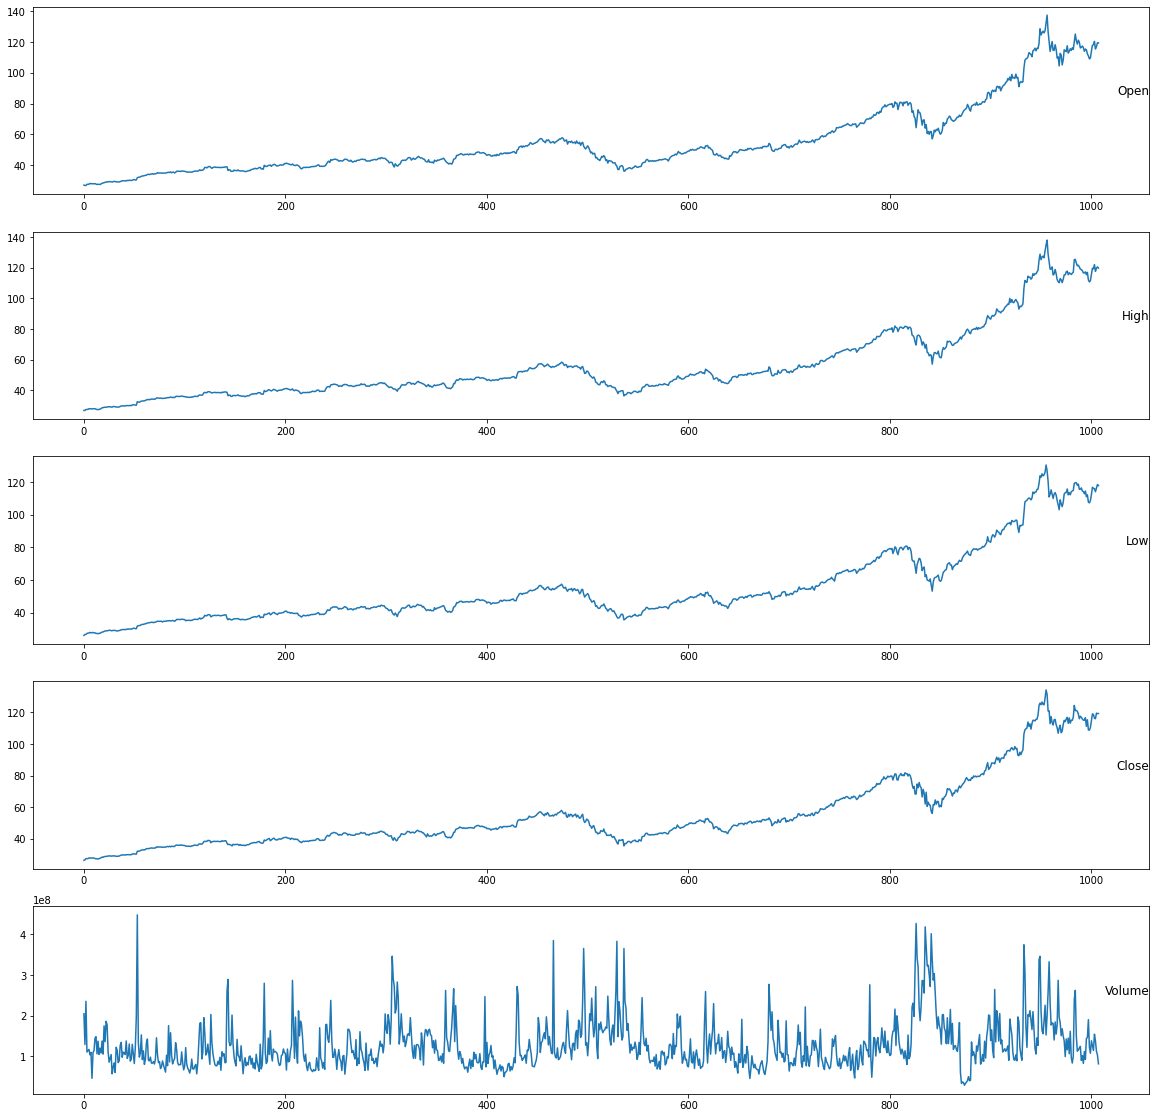

In [12]:
values = dataset.values
# specify columns to plot
groups = [0, 1, 2, 3, 5] 
i = 1
# plot each column
plt.figure(figsize=(20,20))
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group])
    plt.title(dataset.columns[group], y=0.5, loc='right')
    i += 1
plt.show()

'''
Các biến đều có tính trend/session
'''

In [13]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))        
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True) # kết quả sau khi drop gán luôn vào agg
    return agg

In [14]:
#ensure all data is float
values = values.astype('float32')
#normalize features
scaler = MinMaxScaler(feature_range=(0,1))
scaler.fit(values)
scaled = scaler.transform(values)
print('Frame as Series:')
print(scaled[:5])
#frame as supervised learning
reframed = series_to_supervised(scaled,1,1)
print('Frame as supervised learning: ')
print(reframed.head())

Frame as Series:
[[2.5687814e-03 2.9262900e-04 0.0000000e+00 0.0000000e+00 0.0000000e+00
  4.1966838e-01]
 [0.0000000e+00 0.0000000e+00 4.9756020e-03 3.2481849e-03 3.0130148e-03
  2.3919241e-01]
 [2.9292703e-04 5.7401359e-03 6.0281307e-03 9.9301785e-03 9.2111528e-03
  4.9281877e-01]
 [7.3007494e-03 6.0102493e-03 1.1362538e-02 9.8373443e-03 9.1250390e-03
  1.9498245e-01]
 [7.0979595e-03 6.4379573e-03 1.3347998e-02 1.0092571e-02 9.3617886e-03
  2.0258759e-01]]
Frame as supervised learning: 
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)   var1(t)  \
1   0.002569   0.000293   0.000000   0.000000   0.000000   0.419668  0.000000   
2   0.000000   0.000000   0.004976   0.003248   0.003013   0.239192  0.000293   
3   0.000293   0.005740   0.006028   0.009930   0.009211   0.492819  0.007301   
4   0.007301   0.006010   0.011363   0.009837   0.009125   0.194982  0.007098   
5   0.007098   0.006438   0.013348   0.010093   0.009362   0.202588  0.007999   

    var2(t)   var3(

In [15]:
#drop columns we don't want to predict
reframed.drop(reframed.columns[[7,8,9,10,11]],axis = 1,inplace = True)
print("Frame will use:")
print(reframed.head())

Frame will use:
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)   var1(t)
1   0.002569   0.000293   0.000000   0.000000   0.000000   0.419668  0.000000
2   0.000000   0.000000   0.004976   0.003248   0.003013   0.239192  0.000293
3   0.000293   0.005740   0.006028   0.009930   0.009211   0.492819  0.007301
4   0.007301   0.006010   0.011363   0.009837   0.009125   0.194982  0.007098
5   0.007098   0.006438   0.013348   0.010093   0.009362   0.202588  0.007999


### **Split data**

In [16]:
# cột var1(t) là cột cần dự đoán (target)

In [17]:
values = reframed.values
n_train_hours = int(0.7*len(dataset))

In [19]:
train = values[:n_train_hours,:]
test = values[n_train_hours:,:]

train_X,train_y = train[:,:-1],train[:,-1]
test_X,test_y = test[:,:-1],test[:,-1]

print('Before reshape:')
print(train_X.shape,train_y.shape,test_X.shape,test_y.shape)

# reshape input to be 3D [samples,timesteps,features]
train_X = train_X.reshape((train_X.shape[0],1,train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0],1,test_X.shape[1]))

print('After reshape:')
print(train_X.shape,train_y.shape,test_X.shape,test_y.shape)

Before reshape:
(705, 6) (705,) (302, 6) (302,)
After reshape:
(705, 1, 6) (705,) (302, 1, 6) (302,)


### **Build Model**

#### **model 1**

In [21]:
from tensorflow.keras.layers import Dense,Dropout,BatchNormalization
from tensorflow.keras.layers import LSTM,Bidirectional

In [56]:
model = Sequential()
model.add(LSTM(256, activation='relu', return_sequences = True,input_shape = (train_X.shape[1],train_X.shape[2])))
model.add(LSTM(256, activation='relu', return_sequences=True, input_shape=(1, 2)))
model.add(LSTM(128, activation='relu', return_sequences=True))
model.add(LSTM(64, activation='relu', return_sequences=True))
model.add(LSTM(32, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(1))

# Compiling the RNN
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [57]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_25 (LSTM)              (None, 1, 256)            269312    
                                                                 
 lstm_26 (LSTM)              (None, 1, 256)            525312    
                                                                 
 lstm_27 (LSTM)              (None, 1, 128)            197120    
                                                                 
 lstm_28 (LSTM)              (None, 1, 64)             49408     
                                                                 
 lstm_29 (LSTM)              (None, 32)                12416     
                                                                 
 dense_13 (Dense)            (None, 32)                1056      
                                                                 
 dense_14 (Dense)            (None, 10)               

In [58]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
early_stopping = EarlyStopping(min_delta=0.000001,
                              patience = 50,
                              restore_best_weights=True)


In [59]:
history = model.fit(train_X, train_y, 
                    validation_data=(test_X,test_y),
                    epochs = 1000, 
                    batch_size = 256,
                    callbacks=[early_stopping])


Epoch 1/1000
3/3 [==============================] - 8s 450ms/step - loss: 0.0251 - val_loss: 0.2925
Epoch 2/1000
3/3 [==============================] - 0s 83ms/step - loss: 0.0230 - val_loss: 0.2845
Epoch 3/1000
3/3 [==============================] - 0s 78ms/step - loss: 0.0208 - val_loss: 0.2759
Epoch 4/1000
3/3 [==============================] - 0s 80ms/step - loss: 0.0186 - val_loss: 0.2671
Epoch 5/1000
3/3 [==============================] - 0s 95ms/step - loss: 0.0165 - val_loss: 0.2583
Epoch 6/1000
3/3 [==============================] - 0s 84ms/step - loss: 0.0145 - val_loss: 0.2495
Epoch 7/1000
3/3 [==============================] - 0s 82ms/step - loss: 0.0126 - val_loss: 0.2406
Epoch 8/1000
3/3 [==============================] - 0s 80ms/step - loss: 0.0109 - val_loss: 0.2318
Epoch 9/1000
3/3 [==============================] - 0s 80ms/step - loss: 0.0093 - val_loss: 0.2232
Epoch 10/1000
3/3 [==============================] - 0s 80ms/step - loss: 0.0080 - val_loss: 0.2145
Epoch 11

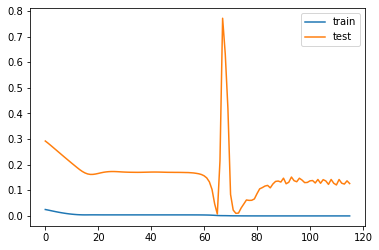

In [60]:
#plot 
plt.plot(history.history['loss'],label='train')
plt.plot(history.history['val_loss'],label='test')
plt.legend()
plt.show()

'''
dù loss ko quá cao có sự lệch giữa train và test
=> có thể thử sử dụng Bidirectional LSTM xem có cải thiện hay ko
'''

In [61]:
def invert_scaling(y, X, s):
    # invert scaling for forecast
    inv_y = np.concatenate((y, X[:, 1:]), axis=1)
    print(s, "shape:", inv_y.shape)
    inv_y = scaler.inverse_transform(inv_y)
    print(s, inv_y.shape)
    # trả lại hình dạng ban đầu
    inv_y = inv_y[:,0]
    return inv_y

In [62]:
# make a prediction
yhat = model.predict(test_X)
print('Test x_shape:', test_X.shape)
test_X_now = test_X.reshape((test_X.shape[0], test_X.shape[2]))
print('test_x_noew_shape: ', test_X_now.shape)

# # invert scaling for forecast
inv_yhat = invert_scaling(yhat, test_X_now, 'inv_yhat')

# invert scaling for actual
test_y = test_y.reshape(len(test_y), 1)
inv_y = invert_scaling(test_y, test_X_now, 'inv_y')

Test x_shape: (302, 1, 6)
test_x_noew_shape:  (302, 6)
inv_yhat shape: (302, 6)
inv_yhat (302, 6)
inv_y shape: (302, 6)
inv_y (302, 6)


In [63]:
# calculate RMSE
rmse = math.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)
mae = mean_absolute_error(inv_y, inv_yhat)
print('Test MAE: %.3f' % mae)

Test RMSE: 9.536
Test MAE: 7.459


RMSE và MAE khá nhỏ => model sử dụng tốt

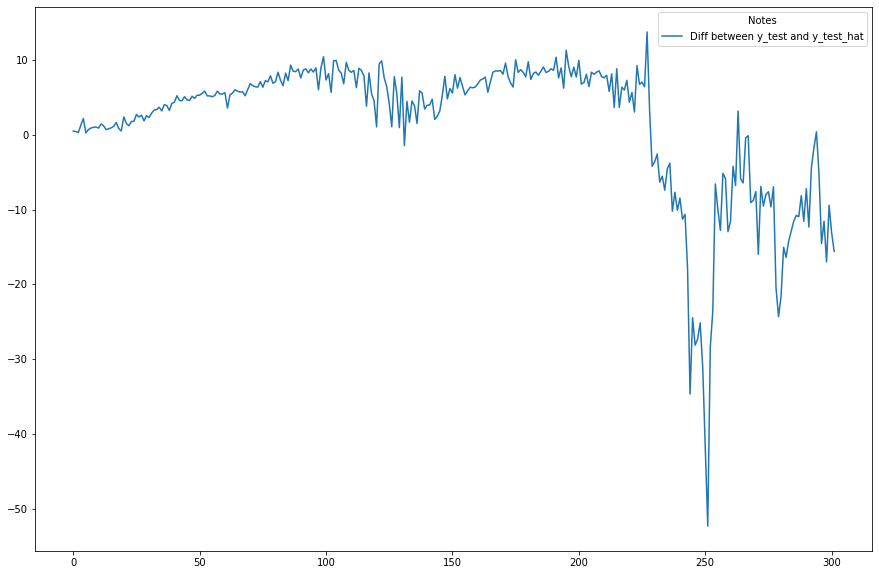

In [64]:
plt.figure(figsize=(15,10))
plt.plot(inv_y - inv_yhat, label='Diff between y_test and y_test_hat')
plt.legend(title="Notes")
plt.show()

In [ ]:
# make a prediction of y
y_train_hat = model.predict(train_X)
train_X_now = train_X.reshape((train_X.shape[0], train_X.shape[2]))

# invert scaling for forecast
inv_y_train_hat = invert_scaling(y_train_hat, train_X_now, "inv_y_train_hat")

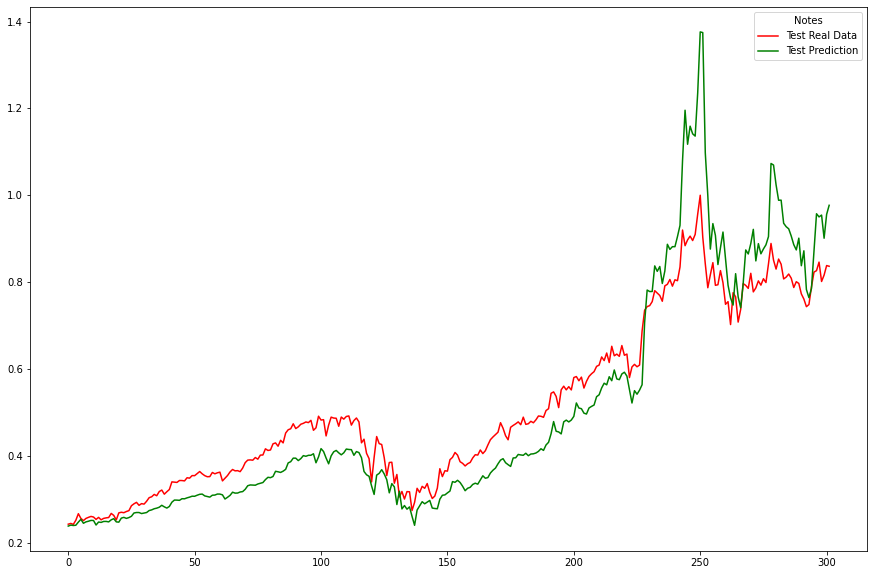

In [65]:
# plot baseline and predictions
plt.figure(figsize=(15,10))
plt.plot(test_y, label='Test Real Data', color='red')
plt.plot(yhat, label='Test Prediction', color='green')
plt.legend(title="Notes")
plt.show()

model 1 dự đoán khá ổn, dù có 1 độ lệch nhất định nhưng về cơ bản vẫn theo xu hướng của real data

#### **model 2**
- Sử dụng Bidirectional xem có cải thiện model hay ko

In [39]:
model2 = Sequential()
model2.add(Bidirectional(LSTM(256, activation='relu', return_sequences = True,input_shape = (train_X.shape[1],train_X.shape[2]))))
model2.add(Batch)
model2.add(Bidirectional(LSTM(256, activation='relu', return_sequences=True, input_shape=(1, 2))))
model2.add(Bidirectional(LSTM(128, activation='relu', return_sequences=True)))
model2.add(Bidirectional(LSTM(64, activation='relu', return_sequences=True)))
model2.add(Bidirectional(LSTM(32, activation='relu')))
model2.add(Dense(20, activation='relu'))
model2.add(Dense(32, activation='relu'))
model2.add(Dense(1))

# Compiling the RNN
model2.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [44]:
model2.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_5 (Bidirectio  (None, 1, 512)           538624    
 nal)                                                            
                                                                 
 bidirectional_6 (Bidirectio  (None, 1, 512)           1574912   
 nal)                                                            
                                                                 
 bidirectional_7 (Bidirectio  (None, 1, 256)           656384    
 nal)                                                            
                                                                 
 bidirectional_8 (Bidirectio  (None, 1, 128)           164352    
 nal)                                                            
                                                                 
 bidirectional_9 (Bidirectio  (None, 64)              

In [41]:
early_stopping = EarlyStopping(min_delta=0.000001,
                              patience = 50,
                              restore_best_weights=True)
learning_rate = ReduceLROnPlateau(patience=10,verbose=1,factor=0.5,min_delta=0.000001)

In [42]:
history2 = model2.fit(train_X, train_y, 
                    validation_data=(test_X,test_y),
                    epochs = 1000, 
                    batch_size = 256,
                    callbacks=[early_stopping])


Epoch 1/1000
3/3 [==============================] - 32s 1s/step - loss: 0.0246 - val_loss: 0.2864
Epoch 2/1000
3/3 [==============================] - 0s 151ms/step - loss: 0.0208 - val_loss: 0.2713
Epoch 3/1000
3/3 [==============================] - 0s 151ms/step - loss: 0.0169 - val_loss: 0.2555
Epoch 4/1000
3/3 [==============================] - 0s 179ms/step - loss: 0.0134 - val_loss: 0.2392
Epoch 5/1000
3/3 [==============================] - 1s 185ms/step - loss: 0.0103 - val_loss: 0.2227
Epoch 6/1000
3/3 [==============================] - 1s 177ms/step - loss: 0.0076 - val_loss: 0.2064
Epoch 7/1000
3/3 [==============================] - 1s 182ms/step - loss: 0.0057 - val_loss: 0.1907
Epoch 8/1000
3/3 [==============================] - 0s 170ms/step - loss: 0.0045 - val_loss: 0.1760
Epoch 9/1000
3/3 [==============================] - 0s 177ms/step - loss: 0.0041 - val_loss: 0.1639
Epoch 10/1000
3/3 [==============================] - 0s 147ms/step - loss: 0.0042 - val_loss: 0.1560
E

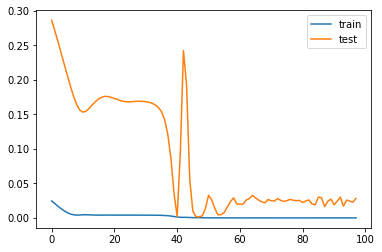

In [43]:
plt.plot(history2.history['loss'],label='train')
plt.plot(history2.history['val_loss'],label='test')
plt.legend()
plt.show()

Thông qua việc sử dụng Bidirectional LSTM thì ta thấy model2 cải thiện hơn model1 rất nhiều

In [55]:
print('val_loss train')
model2.evaluate(train_X,train_y)

print('val_loss test')
model2.evaluate(test_X,test_y)

val_loss train
23/23 [==============================] - 0s 12ms/step - loss: 2.8388e-04
val_loss test
10/10 [==============================] - 2s 15ms/step - loss: 0.0015


0.0015327660366892815

In [45]:
def invert_scaling(y, X, s):
    # invert scaling for forecast
    inv_y = np.concatenate((y, X[:, 1:]), axis=1)
    print(s, "shape:", inv_y.shape)
    inv_y = scaler.inverse_transform(inv_y)
    print(s, inv_y.shape)
    # trả lại hình dạng ban đầu
    inv_y = inv_y[:,0]
    return inv_y

In [46]:
# make a prediction
yhat = model2.predict(test_X)
print('Test x_shape:', test_X.shape)
test_X_now = test_X.reshape((test_X.shape[0], test_X.shape[2]))
print('test_x_noew_shape: ', test_X_now.shape)

# # invert scaling for forecast
inv_yhat = invert_scaling(yhat, test_X_now, 'inv_yhat')

# invert scaling for actual
test_y = test_y.reshape(len(test_y), 1)
inv_y = invert_scaling(test_y, test_X_now, 'inv_y')

Test x_shape: (302, 1, 6)
test_x_noew_shape:  (302, 6)
inv_yhat shape: (302, 6)
inv_yhat (302, 6)
inv_y shape: (302, 6)
inv_y (302, 6)


In [48]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [49]:
# calculate RMSE
rmse = math.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)
mae = mean_absolute_error(inv_y, inv_yhat)
print('Test MAE: %.3f' % mae)

Test RMSE: 4.344
Test MAE: 3.686


In [50]:
dataset.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1.008000e+03
mean,55.022847,55.634645,54.439440,55.068780,53.661965,1.279139e+08
std,22.808228,23.199504,22.329356,22.778370,23.265842,5.914382e+07
min,26.642500,26.920000,26.020000,26.427500,24.825821,2.880380e+07
25%,39.973123,40.278123,39.636251,39.968751,38.069605,8.788140e+07
50%,47.244999,47.631248,46.872500,47.197500,45.769047,1.118354e+08
75%,61.968749,63.971249,61.203751,62.090624,61.046269,1.499102e+08
max,137.589996,137.979996,130.529999,134.179993,133.948898,4.479400e+08


RMSE, MAE nhỏ => model khả dụng

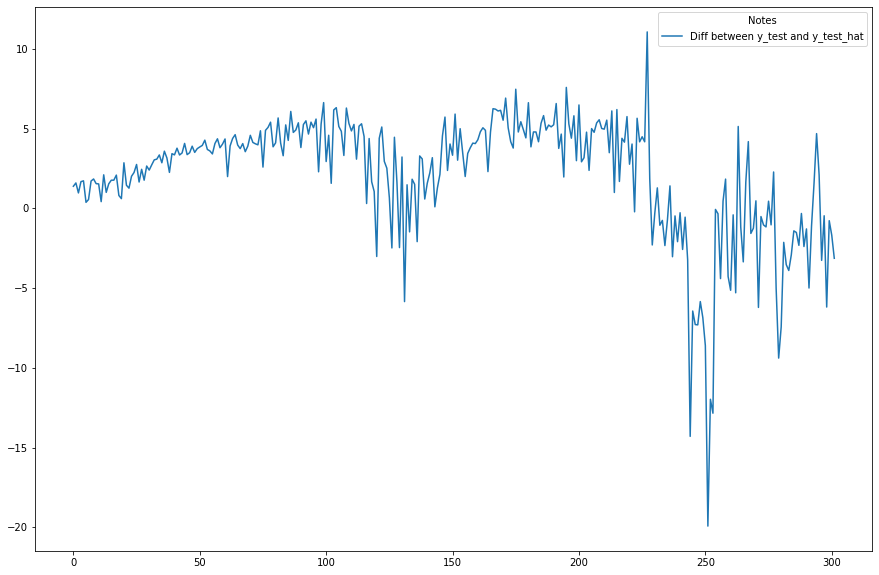

In [51]:
plt.figure(figsize=(15,10))
plt.plot(inv_y-inv_yhat,label="Diff between y_test and y_test_hat")
plt.legend(title='Notes')
plt.show()

In [52]:
y_train_hat = model2.predict(train_X)
train_X_now = train_X.reshape((train_X.shape[0],train_X.shape[2]))

inv_y_train_hat = invert_scaling(y_train_hat,train_X_now,"inv_y_train_hat")

inv_y_train_hat shape: (705, 6)
inv_y_train_hat (705, 6)


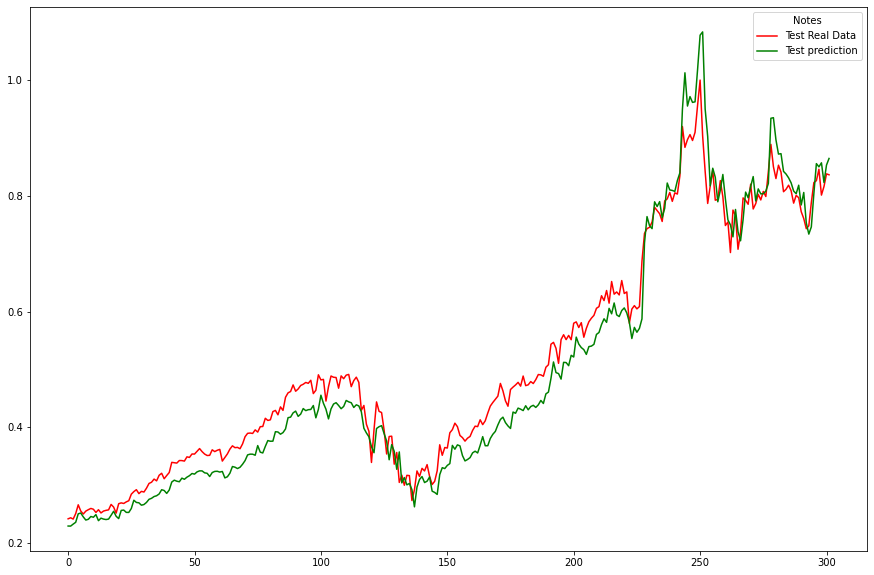

In [53]:
plt.figure(figsize=(15,10))
plt.plot(test_y,label='Test Real Data',color='red')
plt.plot(yhat,label='Test prediction',color ='green')
plt.legend(title='Notes')
plt.show()

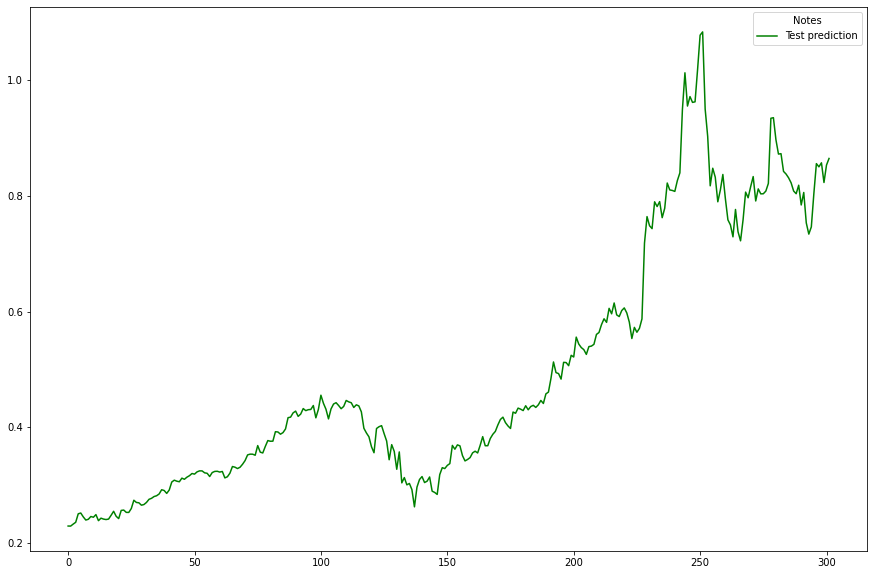

In [54]:
plt.figure(figsize=(15,10))
plt.plot(yhat,label='Test prediction',color ='green')
plt.legend(title='Notes')
plt.show()

Từ 2 biểu đồ trên, ta thấy model 2 với Bidirectional cho ra kết quả tốt hơn so với model 1
=> chọn model 2

### **Save model**

In [66]:
model2.save('LDS8_K275_DinhVietTrung_Cuoi_ky/model/Many_to_One_BiLinear.h5')